### 9.1 Diffusion - Hat vs No Hat CLIP Example 
Reproduces results in Figure 9.8

In [1]:
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
from torch import mps

device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device

'mps'

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True).to(device)
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
def get_common_objects_and_concepts():
    """Curated list of common objects, animals, concepts, emotions, etc."""
    categories = {
        'objects': [
            'chair', 'table', 'car', 'bicycle', 'bottle', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'pizza',
            'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'book', 'clock', 'scissors', 'teddy bear', 'hair dryer',
            'toothbrush', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'man', 'woman'
        ],
        'animals': [
            'person', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
            'giraffe', 'bird', 'chicken', 'duck', 'eagle', 'owl', 'fish', 'shark', 'whale',
            'dolphin', 'turtle', 'frog', 'snake', 'spider', 'bee', 'butterfly', 'lion',
            'tiger', 'fox', 'wolf', 'rabbit', 'hamster', 'mouse', 'rat'
        ],
        'clothing': [
            'hat', 'cap', 'helmet', 'glasses', 'sunglasses', 'shirt', 't-shirt', 'sweater',
            'jacket', 'coat', 'dress', 'skirt', 'pants', 'jeans', 'shorts', 'shoes',
            'sneakers', 'boots', 'sandals', 'socks', 'tie', 'scarf', 'gloves', 'belt',
            'watch', 'ring', 'necklace', 'earrings', 'bracelet'
        ],
        'emotions': [
            'happy', 'sad', 'angry', 'surprised', 'excited', 'calm', 'peaceful', 'joyful',
            'melancholy', 'nostalgic', 'anxious', 'confident', 'mysterious', 'dramatic',
            'romantic', 'energetic', 'serene', 'tense', 'playful', 'serious'
        ],
        'abstract_concepts': [
            'freedom', 'justice', 'peace', 'war', 'love', 'hate', 'beauty', 'ugliness',
            'truth', 'lie', 'innovation', 'tradition', 'progress', 'chaos', 'order',
            'simplicity', 'complexity', 'elegance', 'roughness', 'sophistication'
        ],
        'colors': [
            'red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown',
            'black', 'white', 'gray', 'silver', 'gold', 'cyan', 'magenta', 'lime',
            'navy', 'maroon', 'olive', 'aqua'
        ],
        'styles': [
            'modern', 'vintage', 'classic', 'contemporary', 'abstract', 'realistic',
            'minimalist', 'ornate', 'rustic', 'elegant', 'casual', 'formal', 'artistic',
            'professional', 'creative', 'traditional', 'futuristic', 'retro'
        ],
        'activities': [
            'running', 'walking', 'jumping', 'dancing', 'singing', 'reading', 'writing',
            'cooking', 'eating', 'sleeping', 'working', 'playing', 'studying', 'exercising',
            'swimming', 'flying', 'driving', 'riding', 'climbing', 'surfing'
        ]
    }

    # Flatten all categories
    all_concepts = []
    for category, items in categories.items():
        if category == "objects":
            items = ['A photo of a ' + w for w in items]
        all_concepts.extend(items)

    return all_concepts, categories

In [5]:
words, categories=get_common_objects_and_concepts()
len(words)

208

In [6]:
image = Image.open('data/me_with_hat.jpeg')
image_2 = Image.open('data/me_no_hat_cropped_1.jpeg')

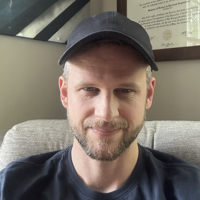

In [7]:
image.resize((200,200)) #Display smaller version

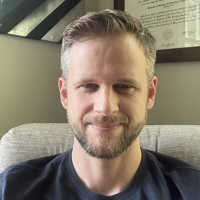

In [8]:
image_2.resize((200,200))

In [9]:
inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

inputs_2 = processor(images=image_2, return_tensors="pt").to(device)
with torch.no_grad():
    image_features_2 = model.get_image_features(**inputs_2)
    image_features_2 = image_features_2 / image_features_2.norm(dim=-1, keepdim=True)

In [10]:
inputs = processor(text=words[0], return_tensors="pt", padding=True).to(device)
with torch.no_grad():
    text_features = model.get_text_features(**inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

In [11]:
batch_size=1024
all_text_features=[]
for i in tqdm(range(int(np.ceil(len(words)/batch_size)))):
    inputs = processor(text=words[i*batch_size:(i+1)*batch_size], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        # Normalize the embeddings
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        all_text_features.append(text_features)
all_text_features=torch.concat(all_text_features)

  0%|          | 0/1 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


In [12]:
all_text_features.shape

torch.Size([208, 512])

In [13]:
similarities = torch.cosine_similarity(image_features-image_features_2, all_text_features, dim=1)

In [14]:
similarities.shape

torch.Size([208])

In [15]:
top_k=10
top_k_indices = similarities.argsort(descending=True)[:top_k]

results = []
for idx in top_k_indices:
    results.append({
        'text': words[idx],
        'similarity': similarities[idx].item()
    })
results

[{'text': 'hat', 'similarity': 0.16519002616405487},
 {'text': 'cap', 'similarity': 0.11290426552295685},
 {'text': 'helmet', 'similarity': 0.10643187910318375},
 {'text': 'angry', 'similarity': 0.06109640747308731},
 {'text': 'roughness', 'similarity': 0.06024686247110367},
 {'text': 'exercising', 'similarity': 0.060203589498996735},
 {'text': 'tense', 'similarity': 0.059934597462415695},
 {'text': 'A photo of a tennis racket', 'similarity': 0.05648532509803772},
 {'text': 'writing', 'similarity': 0.056210167706012726},
 {'text': 'hate', 'similarity': 0.055052708834409714}]

### 9.2 CLIP - Cat Classification Example
Reproduces results from Figure 9.9

In [16]:
def get_common_objects_and_concepts():
    """Curated list of common objects, animals, concepts, emotions, etc."""
    categories = {
        'objects': [
            'chair', 'table', 'car', 'bicycle', 'bottle', 'cup', 'fork', 'knife', 'spoon',
            'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'pizza',
            'donut', 'cake', 'bed', 'toilet', 'laptop', 'mouse', 'remote', 'keyboard',
            'cell phone', 'book', 'clock', 'scissors', 'teddy bear', 'hair dryer',
            'toothbrush', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
            'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
            'skateboard', 'surfboard', 'tennis racket', 'man', 'woman'
        ],
        'animals': [
            'person', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
            'giraffe', 'bird', 'chicken', 'duck', 'eagle', 'owl', 'fish', 'shark', 'whale',
            'dolphin', 'turtle', 'frog', 'snake', 'spider', 'bee', 'butterfly', 'lion',
            'tiger', 'fox', 'wolf', 'rabbit', 'hamster', 'mouse', 'rat'
        ],
        'clothing': [
            'hat', 'cap', 'helmet', 'glasses', 'sunglasses', 'shirt', 't-shirt', 'sweater',
            'jacket', 'coat', 'dress', 'skirt', 'pants', 'jeans', 'shorts', 'shoes',
            'sneakers', 'boots', 'sandals', 'socks', 'tie', 'scarf', 'gloves', 'belt',
            'watch', 'ring', 'necklace', 'earrings', 'bracelet'
        ]
    }

    # Flatten all categories
    all_concepts = []
    for category, items in categories.items():
        if category == "objects":
            items = ['A photo of a ' + w for w in items]
        all_concepts.extend(items)

    return all_concepts, categories

In [17]:
words, categories=get_common_objects_and_concepts()

In [18]:
image = Image.open('data/n02123045_1955.jpg')

inputs = processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    image_features = model.get_image_features(**inputs)
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)

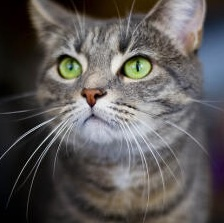

In [19]:
image

In [20]:
all_text_features=[]
for i, word in enumerate(words):
    inputs=processor(text='A photo of a '+ word, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        all_text_features.append(text_features)
all_text_features=torch.concat(all_text_features)

In [21]:
all_text_features.shape

torch.Size([110, 512])

In [22]:
similarities = torch.cosine_similarity(image_features, all_text_features, dim=1)

In [23]:
similarities.shape

torch.Size([110])

In [24]:
top_k = 16
top_k_indices = similarities.argsort(descending=True)[:top_k]

results = []
for idx in top_k_indices:
    print(words[idx], similarities[idx].item())


cat 0.2845577001571655
tiger 0.24450235068798065
socks 0.24046632647514343
boots 0.2389916330575943
mouse 0.2386883646249771
person 0.2367677241563797
rat 0.22938823699951172
dog 0.22791939973831177
sneakers 0.227037712931633
rabbit 0.22683528065681458
necklace 0.22549878060817719
sweater 0.2218007743358612
owl 0.22142702341079712
lion 0.2208843231201172
glasses 0.2206800878047943
A photo of a mouse 0.2203078269958496
